# MNIST database image recognition
In this example we will define and train a neural network to recognise handwritten numbers. First, we import the libraries that we will be using.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Now we can read the .csv files containing the MNIST labeled handwritten numbers dataset.

In [2]:
image_size = 28 # width and length of the images in pixels
data_path = "numbers/" # path of the .csv files with the numbers and labels

# We load the training data as a numpy array. This array includes the label in the first position.
print('Loading the training data...')
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
print('Loaded training array of dimensions {}x{}'.format(np.shape(train_data)[0],np.shape(train_data)[1]))

# We load the test data as a numpy array. This array includes the label in the first position.
print('Loading the test data...')
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",")
print('Loaded test array of dimensions {}x{}'.format(np.shape(test_data)[0],np.shape(test_data)[1]))



# Translate the labels of each image in the training dataset (number from 0 to 9)
# to an array filled with zeros and a 1 in the position of the label
auxiliar_train = np.zeros((len(train_data), 10))
for i in range(len(train_data)):
    value = int(train_data[i,0])
    auxiliar_train[i,value] = 1

# Translate the labels of each image in the test dataset (number from 0 to 9)
# to an array filled with zeros and a 1 in the position of the label
auxiliar_test = np.zeros((len(test_data), 10))
for i in range(len(test_data)):
    value = int(test_data[i,0])
    auxiliar_test[i,value] = 1

    
    
# Save the images (normalised) and labels as PyTorch tensors
train_labels = torch.Tensor(auxiliar_train)
train_images = torch.Tensor(train_data[:,1:])/255.
test_labels = torch.Tensor(auxiliar_test)
test_images = torch.Tensor(test_data[:,1:])/255.

Loading the training data...
Loaded training array of dimensions 60000x785
Loading the test data...
Loaded test array of dimensions 10000x785


We can check the dimensions of our train_images array

In [4]:
train_images.size()

torch.Size([60000, 784])

It is easy to show the image of one element of the dataset. We just have to reshape one of the elements of train_images/test_images to dimension 28x28, since in the database they are flattened to be of dimension 784.

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


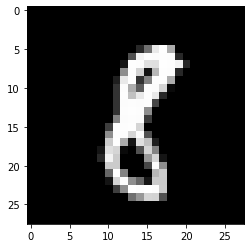

In [5]:
# Select a random element of the database
index = np.random.randint(0,60000)
plt.gray()
# Show the reshaped tensor as a 28x28 image
plt.imshow(train_images[index].view(image_size, image_size))
print('Label: {}'.format(train_labels[index]))

Now we have to define our neural network. The process is similar to the previous single neuron case, but now we will have an input of dimension image_size*image_size for the first layer and we will have four hidden layers. The number in the output of one of the hidden layers must be equal to the number in the input of the next hidden layer.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Hidden layer of 256 neurons
            nn.Linear(image_size*image_size, 256),
            nn.ReLU(),
            # Hidden layer of 128 neurons
            nn.Linear(256, 128),
            nn.ReLU(),
            # Hidden layer of 64 neurons
            nn.Linear(128, 64),
            nn.ReLU(),
            # Output
            nn.Linear(64, 10),
            )
                
    def forward(self, input):
            output = self.main(input)
            output = torch.tanh(output)
            return output        

This neural network is initialised randomly. Thus, if we pass one of the numbers from the dataset through it, the output will be random.

In [7]:
net = Net()
print(net(train_images[1]))

tensor([ 0.0174,  0.1559, -0.0175,  0.0738,  0.0313,  0.0226, -0.0994,  0.1603,
        -0.0942,  0.0058], grad_fn=<TanhBackward>)


Now we just have to define the optimizer (we will use the "Adam" optimizer) and the criterion (MSELoss)

In [8]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

Instead of training the neural network image by image, we will use batches of several images. We will pass a batch to the neural network, accumulate the gradients, and once the batch is completed we will perform the backpropagation.

In [9]:
# Example of a batch of 10 images
batch = train_images[0:20]
# Print the output of the batch through the network
print(net(batch).size())

torch.Size([20, 10])


The result is a tensor of twenty results (the batch size that we used) of ten components each (the possible number outputs). Now we have everything ready to perform the training process

In [10]:
BATCH_SIZE = 100
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in range(0, len(train_labels), BATCH_SIZE):
        batch_images = train_images[i:i+BATCH_SIZE]
        batch_labels = train_labels[i:i+BATCH_SIZE]
        
        net.zero_grad()
        
        outputs = net(batch_images)
        
        loss = criterion(outputs, batch_labels)
        loss.backward()
        
        optimizer.step()
        print('Epoch {} // Step {}/{}'.format(epoch, int(i/BATCH_SIZE), int(len(train_labels)/BATCH_SIZE)), end='\r')

After the training we can check the performance of the neural network by using the test dataset that we created. We are going to count the total of correct answers given by the neural network and save the index of the incorrect guesses for posterior visualization

In [11]:
correct = 0
total = 0
error = []
with torch.no_grad():
    for i in range(len(test_images)):
        real_class = torch.argmax(test_labels[i])
        out = net(test_images[i])
        predicted = torch.argmax(out)
        if predicted == real_class:
            correct +=1
        else:
            error.append(i)
        total +=1
print(correct/total)

0.9771


True value: 9
Neural network outcome 4


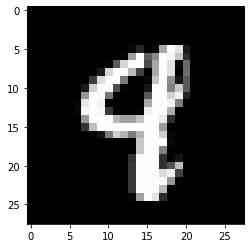

In [12]:
error_number = 5
plt.imshow(test_images[error[error_number]].view(28,28))
print("True value: {}".format(torch.argmax(test_labels[error[error_number]])))
print("Neural network outcome {}".format(torch.argmax(net(test_images[error[error_number]]))))